In [1]:
#import basic system functions
import os
import datetime
from collections import Counter

#import libraries for data wrangling
import pandas as pd
import numpy as np

#import libraries for plotting data
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#import libraries for time series analysis
from fbprophet import Prophet

#import libraries to evaluate model performance
import sklearn.metrics as metrics

In [2]:
#import list with features descriptions
feature_description = pd.read_csv('meteolytix_Artikelgruppen.csv')

#create dictionary with article group descriptions
article_names = {int(item[:2].replace(';','')):item[2:].replace(';','').replace(' ','') for item in feature_description['Artikelgruppe;Name']}
article_names

#delete feature description dataframe
del feature_description

In [3]:
#create dataframe with original data that will not be touched throughout notebook
original_data = pd.read_csv('meteolytix_Artikelgruppen_Umsatz_verschiedeneStandorte.csv') 

In [4]:
#set Datum to datetime format
original_data['Datum'] = pd.to_datetime(original_data['Datum'])

In [5]:
#convert date to index
original_data.set_index('Datum', inplace=True)
original_data.sort_index(inplace=True)

In [6]:
#convert Filiale and Artikel ID to integer
original_data.Filiale = [int(no) for no in original_data.Filiale]
original_data.Artikelgruppe = [int(no) for no in original_data.Artikelgruppe]

# Split dataset into train, validation & test

In [7]:
train_df = original_data[original_data.index.year < 2018]
validation_df = original_data[original_data.index.year == 2018]
test_df = original_data[original_data.index.year == 2019]
corona_df = original_data[original_data.index.year == 2020]

# Build pipeline to transform dataframes to desired format and add features

# Build predictive models

## Naive prediction model as baseline

In later stages of the notebook, we will build sophisticated models to predict the revenue generated by each article group in each store for a given time period. To determine if a model is good or not, it has to be measured against some benchmark. In this case, our benchmark model will be a very simple technique: To predict the sales on a given day, we will just assume the same quantity as in a previous period (e.g. previous day or same day in previous week or previous year). Because we identified heavy inter-weekly patterns in the data, we will not use the previous day as a predictor but the same day in a previous period.

Since one store sells much more 'Brötchen' while the other has relatively high peaks in other categories, we will build a model for each product group for each store. This way, we avoid using the very same model for either one product category in all stores or for all product categories in one store. 

In [33]:
y_true = test_df.loc[(test_df.Filiale == 1)&(test_df.Artikelgruppe == 1)]['Umsatz'].sort_index()
def naive_lag_prediction(y_true, lag=7):
    return y_true.shift(lag)    

In [34]:
#create empty dataframe to store results of prediction iterations
naive_model_performance= pd.DataFrame(columns=['Filiale','Artikelgruppe','MAE','MED_AE','MSE','R2'])

In [35]:
#iterate through all stores and article groups to predict each days revenue with the revenue from last week
for fil in train_df.Filiale.unique():
    for article in train_df.Artikelgruppe.unique():
        #generate series with true values
        y_true = train_df.loc[(train_df['Filiale'] == fil)&(train_df['Artikelgruppe'] == article)]['Umsatz'].sort_index(ascending=True)
        
        #predict values of series with value from 7 periods before (predict value for next Monday with value from this Monday)
        y_predict = naive_lag_prediction(y_true,lag=7)
         
        #delete first 7 digits for both series, because prediction contains NAN values
        y_true = y_true[7:]
        y_predict = y_predict[7:]
        
        #get model performance metrics
        mae = metrics.mean_absolute_error(y_true,y_predict)
        medae = metrics.median_absolute_error(y_true,y_predict)
        mse = metrics.mean_squared_error(y_true,y_predict)
        r2 = metrics.r2_score(y_true,y_predict)
        
        naive_model_performance = naive_model_performance.append({'Filiale':fil,'Artikelgruppe':article,'MAE':mae,'MED_AE':medae,'MSE':mse,'R2':r2}, ignore_index=True)


In [36]:
naive_model_performance

,Filiale,Artikelgruppe,MAE,MED_AE,MSE,R2
0,2.0,1.0,13.861837,11.321194,305.055805,-0.822229
1,2.0,2.0,14.862158,12.376047,357.066192,-0.477559
2,2.0,8.0,18.761657,15.780797,575.536073,0.148034
3,2.0,5.0,13.922044,10.951583,389.388460,-0.710698
4,2.0,9.0,18.915792,15.521498,586.672534,-0.417615
5,2.0,11.0,41.055783,25.078582,13402.148108,-0.725361
6,2.0,4.0,15.184859,12.434395,405.437478,-0.616785
7,2.0,12.0,27.821560,20.920293,1427.137788,0.252721
8,2.0,3.0,17.419732,14.612210,499.530440,-0.764388
9,2.0,7.0,23.295831,16.863039,1067.664379,0.538868


Let's have a look at which group of articles is being predicted best and worst by the naive model

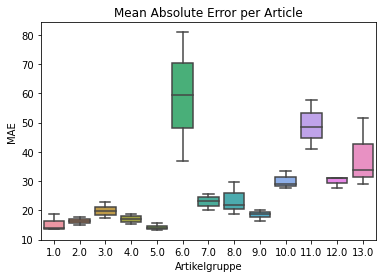

In [37]:
sns.boxplot(x = 'Artikelgruppe', y = 'MAE', data=naive_model_performance,orient='v')
plt.title('Mean Absolute Error per Article');

px.scatter(data_frame=naive_model_performance, x='Artikelgruppe', y= 'MAE',color='Filiale',title='Mean Absolute Error per Article and Store' )

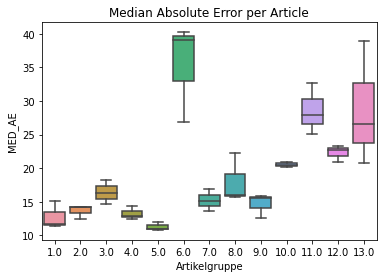

In [41]:
sns.boxplot(x = 'Artikelgruppe', y = 'MED_AE', data=naive_model_performance,orient='v')
plt.title('Median Absolute Error per Article');

px.scatter(data_frame=naive_model_performance, x='Artikelgruppe', y= 'MED_AE',color='Filiale',title='Median Absolute Error per Article and Store' )

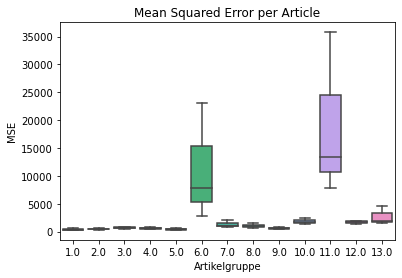

In [39]:
sns.boxplot(x = 'Artikelgruppe', y = 'MSE', data=naive_model_performance,orient='v')
plt.title('Mean Squared Error per Article');

px.scatter(data_frame=naive_model_performance, x='Artikelgruppe', y= 'MSE',color='Filiale',title='Mean Squared Error per Article and Store' )

The plots show that the model performs similar for all 3 stores. When it is good at predicting an article in store 1, it is also rather good at predicting the article in the other stores. The model is quite ok at predicting the sales of article groups 1-5 which are all related to whole loafs of bread. Article groups 6 (Brötchen) and 11 (Stückgebäck) seem to be less predictable with this model. The problems with article group 11 could be related to the fact that this article shows very high outliers at around new years eve. <br>

Interestingly, it is store 3 that generates the highest mean and median absolute error. This is the store located in the suburb and intuitively I would have thought that the sales at the beach are more dependent on external factors and thus fluctuate more from week to week. 